In [10]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
import os, codecs
%matplotlib inline
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

In [2]:
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in codecs.open(os.path.join(self.dirname, fname)) :
                yield line.split()

In [65]:
num_features = 300
model = gensim.models.Word2Vec.load_word2vec_format('/home/bahbbc/Documents/personality_1', encoding='utf8', unicode_errors='ignore')
#model = Word2Vec.load_word2vec_format('/home/bahbbc/Documents/teste-personalidade/personality_1',binary=True)
model.init_sims(replace=True)

2017-02-12 20:11:22,440 : INFO : loading projection weights from /home/bahbbc/Documents/personality_1
2017-02-12 20:12:40,941 : INFO : loaded (288722, 300) matrix from /home/bahbbc/Documents/personality_1
2017-02-12 20:12:41,047 : INFO : precomputing L2-norms of word weight vectors


### Verify model with personality

In [36]:
df = pd.read_csv('~/personality-normalized-word2vec.csv', encoding='utf_8')
df = df.dropna()

In [37]:
df.agreeabeness_m.value_counts()

1    236
0    191
Name: agreeabeness_m, dtype: int64

In [39]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

### Evaluation code

In [40]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    target_names = ['no', 'yes']
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [42]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['formatted_text'])
    predictions = classifier.predict(data_features)
    target = data['agreeabeness_m']
    evaluate_prediction(predictions, target)

### Word2Vec model training

In [43]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.wv.vocab:
            mean.append(wv.wv.syn0norm[wv.wv.vocab[word].index])
            all_words.add(wv.wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(num_features,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [44]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='portuguese'):
        for word in nltk.word_tokenize(sent, language='portuguese'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [45]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [46]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

2017-02-12 18:58:58,326 : WARNING : cannot compute similarity with no input []
2017-02-12 18:58:58,622 : WARNING : cannot compute similarity with no input []
2017-02-12 18:58:58,691 : WARNING : cannot compute similarity with no input []


CPU times: user 1.8 s, sys: 22.8 ms, total: 1.82 s
Wall time: 1.9 s


In [47]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['agreeabeness_m'])
predicted = logreg.predict(X_test_word_average)

CPU times: user 249 ms, sys: 0 ns, total: 249 ms
Wall time: 251 ms


accuracy 0.581395348837
confusion matrix
 [[34 35]
 [19 41]]
(row=expected, col=predicted)


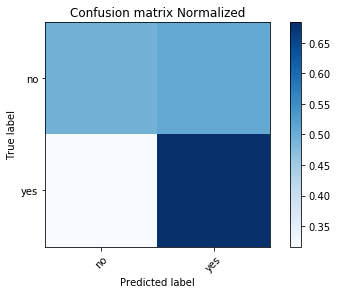

In [139]:
evaluate_prediction(predicted, test_data.agreeabeness_m)

## Remove stop words

In [48]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='portuguese'):
        for word in nltk.word_tokenize(sent, language='portuguese'):
            if len(word) < 2:
                continue
            if word in stopwords.words('portuguese'):
                continue
            tokens.append(word)
    return tokens

In [49]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [50]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

2017-02-12 19:01:31,835 : WARNING : cannot compute similarity with no input []
2017-02-12 19:01:32,078 : WARNING : cannot compute similarity with no input []
2017-02-12 19:01:32,129 : WARNING : cannot compute similarity with no input []


CPU times: user 1.41 s, sys: 5.69 ms, total: 1.42 s
Wall time: 1.43 s


In [51]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['agreeabeness_m'])
predicted = logreg.predict(X_test_word_average)

CPU times: user 290 ms, sys: 10.9 ms, total: 301 ms
Wall time: 297 ms


accuracy 0.658914728682
confusion matrix
 [[34 25]
 [19 51]]
(row=expected, col=predicted)


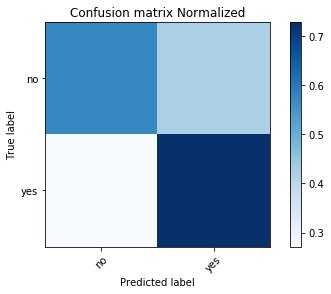

In [52]:
evaluate_prediction(predicted, test_data.agreeabeness_m)

Fitting a random forest to labeled training data...
accuracy 0.565891472868
confusion matrix
 [[21 38]
 [18 52]]
(row=expected, col=predicted)


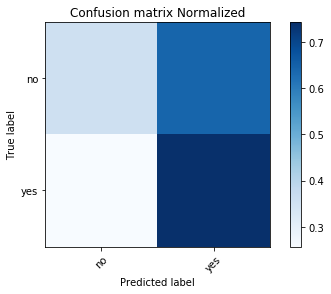

In [64]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100 )

print "Fitting a random forest to labeled training data..."
forest = forest.fit( X_train_word_average, train_data["agreeabeness_m"] )

# Test & extract results 
result = forest.predict( X_test_word_average )

evaluate_prediction(result, test_data.agreeabeness_m)

## Doc2Vec

In [53]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [55]:

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [56]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['formatted_text']), tags=[r.agreeabeness_m]), axis=1)

In [57]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['formatted_text']), tags=[r.agreeabeness_m]), axis=1)

In [58]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

2017-02-12 19:03:52,531 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-02-12 19:03:52,534 : INFO : collecting all words and their counts
2017-02-12 19:03:52,536 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-02-12 19:03:52,729 : INFO : collected 58096 word types and 2 unique tags from a corpus of 298 examples and 594855 words
2017-02-12 19:03:52,730 : INFO : Loading a fresh vocabulary
2017-02-12 19:03:52,803 : INFO : min_count=5 retains 10457 unique words (17% of original 58096, drops 47639)
2017-02-12 19:03:52,803 : INFO : min_count=5 leaves 525071 word corpus (88% of original 594855, drops 69784)
2017-02-12 19:03:52,838 : INFO : deleting the raw counts dictionary of 58096 items
2017-02-12 19:03:52,841 : INFO : sample=0.001 downsamples 48 most-common words
2017-02-12 19:03:52,842 : INFO : downsampling leaves estimated 434415 word corpus (82.7% of prior 525071)
2017-02-12 19:03:52,843 : INFO : estimated requ

CPU times: user 23.3 s, sys: 129 ms, total: 23.5 s
Wall time: 23.4 s


In [59]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

CPU times: user 3.57 s, sys: 1.83 ms, total: 3.57 s
Wall time: 3.58 s


accuracy 0.558139534884
confusion matrix
 [[23 36]
 [21 49]]
(row=expected, col=predicted)


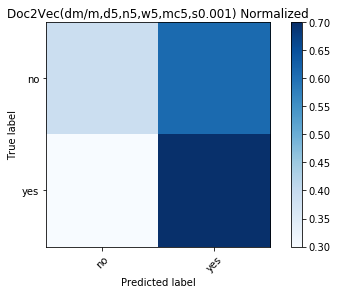

In [60]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))

2017-02-12 19:04:19,804 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.612403100775
confusion matrix
 [[28 31]
 [19 51]]
(row=expected, col=predicted)
CPU times: user 156 ms, sys: 102 ms, total: 258 ms
Wall time: 153 ms


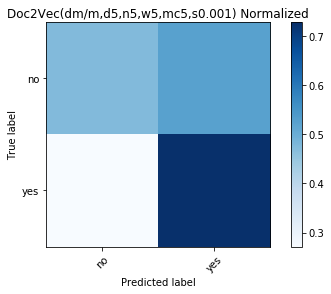

In [61]:
%%time 
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, str(doc2vec_model))

Fitting a random forest to labeled training data...
accuracy 0.596899224806
confusion matrix
 [[27 32]
 [20 50]]
(row=expected, col=predicted)


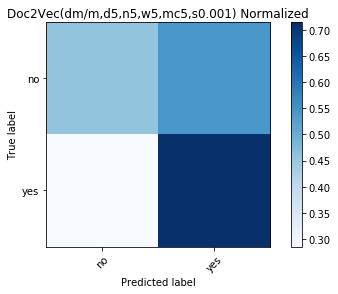

In [63]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100 )

print "Fitting a random forest to labeled training data..."
forest = forest.fit( train_regressors, train_data["agreeabeness_m"] )

# Test & extract results 
result = forest.predict( test_regressors )

evaluate_prediction(result, test_targets, str(doc2vec_model))